Previous notebook is `/pscratch/sd/y/yaswante/MyQuota/roman_lsst/LSST_Roman_MasterCatalogs.ipynb`

In [33]:
import os, re, json, time, gc, sys, glob, random, traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.visualization import AsinhStretch, MinMaxInterval, ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from scipy.ndimage import zoom
from collections import defaultdict

from lsst.afw.image import exposure
from lsst.afw.image import ExposureF
import lsst.daf.butler as Butler
import lsst.daf.persistence as dafPersist
import lsst.geom as geom
from lsst.afw.fits import makeLimitedFitsHeader

import multiprocessing as mp
from functools import partial
from tqdm import tqdm
pd.options.mode.chained_assignment = None

In [2]:
# --- Setup LSST Butler and Skymap ---
repo = '/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2'
butler = dafPersist.Butler(repo)
skymap = butler.get("deepCoadd_skyMap")

In [113]:
import pickle
with open('/pscratch/sd/y/yaswante/MyQuota/roman_lsst/dr6_deepCoadd_skyMap.pkl', 'wb') as f:
    pickle.dump(skymap, f)

# Exploring Butler

In [27]:
print(dir(butler))

['GENERATION', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_addParents', '_assignDefaultMapper', '_connectParentRepoDatas', '_convertV1Args', '_getBypassFunc', '_getCfgs', '_getDefaultMapper', '_getOldButlerRepositoryCfg', '_getParentRepoData', '_getParentVal', '_getParents', '_getRepositoryCfg', '_initArgs', '_initRepo', '_locate', '_processInputArguments', '_read', '_repos', '_resolveDatasetTypeAlias', '_setAndVerifyParentsLists', '_setDefaultMapper', '_setRepoDataTags', 'dataRef', 'datasetExists', 'datasetTypeAliasDict', 'defineAlias', 'get', 'getKeys', 'getMapperClass', 'getUri', 'log', 'put', 'queryMetadata', 'storage', 'subset']


In [16]:
print(f"Using GEN {butler.GENERATION} Butler:")
role_dict = defaultdict(list)
for repo_data in butler._repos._all:
    role_dict[repo_data.role].append(repo_data.repoArgs.root)
for role, paths in role_dict.items():
    print(f"\n Role: {role}")
    for path in paths:
        print(f"  - {path}")

Using GEN 2 Butler:

 Role: output
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2

 Role: input
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-calexp-v1
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2-u
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2-grizy
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0

 Role: parent
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-calexp-v1
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0
  - /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-calexp-v1


- **Input repo:** A data source that the Butler reads from. Existing repos that provide data for processing or analysis
- **Output repo:** A data destination where Butler writes results or derived data. Newly created or existing repos that store the results of Butler's processing
- **Parent repo:** A repo that serves as a foundational or referenced repo. Parent repos are linked to input or output repos and can be part of a DAG of repos. They provide metadata or shared data that is accessible during the Butler's operations.

Butler manages data by creating a DAG of these repos, where output repos may have input repos as parents, and input repos are sources of data. 

From the LSST Pipeline documentation, the Butler initialization sequences load inputs, outputs, and their respective parents to form the repo hierarchy and resolve accesses accordingly.[1][2]

Links:
[1] [LSST Applications: lsst.daf.persistence.butler.Butler Class Reference](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1daf_1_1persistence_1_1butler_1_1_butler.html)  
[2] [[PDF] The Vera C. Rubin Observatory Data Butler and Pipeline Execution ...](https://arxiv.org/pdf/2206.14941.pdf)  
Other Sources:
[butler - LSST Science Pipelines](https://pipelines.lsst.io/modules/lsst.daf.butler/scripts/butler.html)  
 [LSSTApplications: lsst.daf.persistence.butler.Butler Class Reference](http://doxygen.lsst.codes/stack/doxygen/xlink_master_2019_11_16_09.13.30/classlsst_1_1daf_1_1persistence_1_1butler_1_1_butler.html)  
[Butler v29.1.0 (2025-06-13) - LSST Science Pipelines](https://pipelines.lsst.io/modules/lsst.daf.butler/CHANGES.html)  
[Setting in-repository policy via Butler - Data Management](https://community.lsst.org/t/setting-in-repository-policy-via-butler/1268)  
[How to create your own data butler - LSST-France User Guide](https://doc.lsst.eu/tutorial/butler.html)  
 [Getting started tutorial part 1: setting up the Butler data repository](https://community.lsst.org/t/getting-started-tutorial-part-1-setting-up-the-butler-data-repository/9611)  
[lsst/rtn-029: Procedure for creating a butler repository from ... - GitHub](https://github.com/lsst/rtn-029)  
[How to use the main butler repo — doc.lsst.eu documentation](https://doc.lsst.eu/tutorial/main_butler.html)

In [17]:
print(f"So, we will be using the output repo: {repo} where all of the data we need will exist.")

So, we will be using the output repo: /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/rerun/run2.2i-dr6-v2 where all of the data we need will exist.


In [7]:
MapperClass = butler.getMapperClass(repo)  # get Mapper class bound to repo
mapper = MapperClass()  # instantiate the Mapper
dataset_types = mapper.getDatasetTypes()

# Exploring Butler DeepCoadd DatasetTypes

In [28]:
target = 'deepCoadd'
matching_types = [item for item in dataset_types if target in item]
print(f"Found {len(matching_types)} matches:")
for match in matching_types:
    print(match)
    # mapper.getKeys(match, level='')

Found 219 matches:
deepCoadd
deepCoaddId
deepCoaddId_bits
deepCoaddId_bits_filename
deepCoaddId_filename
deepCoaddPsfMatched
deepCoaddPsfMatched_bbox
deepCoaddPsfMatched_detector
deepCoaddPsfMatched_filename
deepCoaddPsfMatched_filter
deepCoaddPsfMatched_header_wcs
deepCoaddPsfMatched_md
deepCoaddPsfMatched_photoCalib
deepCoaddPsfMatched_sub
deepCoaddPsfMatched_visitInfo
deepCoaddPsfMatched_wcs
deepCoadd_bbox
deepCoadd_calexp
deepCoadd_calexp_background
deepCoadd_calexp_background_filename
deepCoadd_calexp_background_len
deepCoadd_calexp_background_md
deepCoadd_calexp_background_schema
deepCoadd_calexp_bbox
deepCoadd_calexp_detector
deepCoadd_calexp_filename
deepCoadd_calexp_filter
deepCoadd_calexp_header_wcs
deepCoadd_calexp_md
deepCoadd_calexp_photoCalib
deepCoadd_calexp_sub
deepCoadd_calexp_visitInfo
deepCoadd_calexp_wcs
deepCoadd_deblendedFlux
deepCoadd_deblendedFlux_filename
deepCoadd_deblendedFlux_len
deepCoadd_deblendedFlux_md
deepCoadd_deblendedFlux_schema
deepCoadd_deblendedFl

In [84]:
help(mapper.getKeys)

Help on method getKeys in module lsst.obs.base.cameraMapper:

getKeys(datasetType, level) method of lsst.obs.lsst.imsim.ImsimMapper instance
    Return a dict of supported keys and their value types for a given
    dataset type at a given level of the key hierarchy.
    
    Parameters
    ----------
    datasetType :  `str`
        Dataset type or None for all dataset types.
    level :  `str` or None
        Level or None for all levels or '' for the default level for the
        camera.
    
    Returns
    -------
    `dict`
        Keys are strings usable in a dataset identifier, values are their
        value types.



In [102]:
mapper.getKeys('deepCoadd_calexp', level='')

{'filter': str, 'tract': int, 'patch': str}

- `deepCoadd_calexp`: Loads the full image for the requested sky patch or tract. Returns an Exposure object representing the entire coadd, with all pixels, headers, and metadata.
- `deepCoadd_calexp_sub`: Loads only the subset of pixels specified by our bounding box (bbox argument). Used when we need a small spatial region or want to extract metadata/header with minimal pixel data

# Getting Full Coadd Images of Overlapping Regions with Roman

In [3]:
root_dir = '/pscratch/sd/y/yaswante/MyQuota/roman_lsst/'

In [18]:
lsst_master_truth = pd.read_parquet(f'{root_dir}lsst_master_truth_df_700.parquet') # has 24748131 unique entries each with their own id

In [18]:
# tract_patch_summary = lsst_master_truth.groupby('tract')['patch'].apply(lambda x: sorted(x.unique())).to_dict()
with open(os.path.join(root_dir, "overlap_tract_patches_700.json"), "r") as f:
    tract_patch_summary = json.load(f)
print(f"Our Overlapping {len(tract_patch_summary)} Tracts and their corresponding overlapping patches:")
for tract, patches in tract_patch_summary.items():
    print(f"Tract {tract}: {len(patches)} patches - {patches}")

Our Overlapping 11 Tracts and their corresponding overlapping patches:
Tract 3075: 21 patches - ['0,4', '0,5', '0,6', '1,4', '1,5', '1,6', '2,4', '2,5', '2,6', '3,4', '3,5', '3,6', '4,4', '4,5', '4,6', '5,4', '5,5', '5,6', '6,4', '6,5', '6,6']
Tract 3076: 21 patches - ['0,4', '0,5', '0,6', '1,4', '1,5', '1,6', '2,4', '2,5', '2,6', '3,4', '3,5', '3,6', '4,4', '4,5', '4,6', '5,4', '5,5', '5,6', '6,4', '6,5', '6,6']
Tract 3256: 21 patches - ['0,0', '0,1', '0,2', '0,3', '0,4', '0,5', '0,6', '1,0', '1,1', '1,2', '1,3', '1,4', '1,5', '1,6', '2,0', '2,1', '2,2', '2,3', '2,4', '2,5', '2,6']
Tract 3257: 49 patches - ['0,0', '0,1', '0,2', '0,3', '0,4', '0,5', '0,6', '1,0', '1,1', '1,2', '1,3', '1,4', '1,5', '1,6', '2,0', '2,1', '2,2', '2,3', '2,4', '2,5', '2,6', '3,0', '3,1', '3,2', '3,3', '3,4', '3,5', '3,6', '4,0', '4,1', '4,2', '4,3', '4,4', '4,5', '4,6', '5,0', '5,1', '5,2', '5,3', '5,4', '5,5', '5,6', '6,0', '6,1', '6,2', '6,3', '6,4', '6,5', '6,6']
Tract 3258: 28 patches - ['3,0', '3,1', '

In [30]:
output_path = os.path.join(root_dir, "overlap_tract_patches_700.json")
with open(output_path, "w") as f:
    json.dump(tract_patch_summary, f, indent=2)
print(f"Overlapping tracts and their patches saved to {output_path}")

Overlapping Tracts and their patches saved to /pscratch/sd/y/yaswante/MyQuota/roman_lsst/overlap_tract_patches_700.json


In [34]:
print("Number of unique (tract, patch) pairs:", sum(len(patches) for patches in tract_patch_summary.values()))

Number of unique (tract, patch) pairs: 305


Since we'll also need the coadd for *each band (ugrizy)*, we will be doing a total of 305*6= **1830 Butler calls**. This is much better than doing hundreds of thousands of Butler calls for each individual Roman cutout.

In [19]:
bands = ['u', 'g', 'r', 'i', 'z', 'y']
all_coaddIds = [
    {'tract': int(tract), 'patch': patch, 'filter': band} 
    for band in bands
    for tract, patches in tract_patch_summary.items()
    for patch in patches
]
print(f"We have {len(all_coaddIds)} dataIds we will pass to Butler.")

We have 1830 dataIds we will pass to Butler.


In [53]:
all_coaddIds[:10], all_coaddIds[306:315], all_coaddIds[-10:]

([{'tract': 3075, 'patch': '0,4', 'filter': 'u'},
  {'tract': 3075, 'patch': '0,5', 'filter': 'u'},
  {'tract': 3075, 'patch': '0,6', 'filter': 'u'},
  {'tract': 3075, 'patch': '1,4', 'filter': 'u'},
  {'tract': 3075, 'patch': '1,5', 'filter': 'u'},
  {'tract': 3075, 'patch': '1,6', 'filter': 'u'},
  {'tract': 3075, 'patch': '2,4', 'filter': 'u'},
  {'tract': 3075, 'patch': '2,5', 'filter': 'u'},
  {'tract': 3075, 'patch': '2,6', 'filter': 'u'},
  {'tract': 3075, 'patch': '3,4', 'filter': 'u'}],
 [{'tract': 3075, 'patch': '0,5', 'filter': 'g'},
  {'tract': 3075, 'patch': '0,6', 'filter': 'g'},
  {'tract': 3075, 'patch': '1,4', 'filter': 'g'},
  {'tract': 3075, 'patch': '1,5', 'filter': 'g'},
  {'tract': 3075, 'patch': '1,6', 'filter': 'g'},
  {'tract': 3075, 'patch': '2,4', 'filter': 'g'},
  {'tract': 3075, 'patch': '2,5', 'filter': 'g'},
  {'tract': 3075, 'patch': '2,6', 'filter': 'g'},
  {'tract': 3075, 'patch': '3,4', 'filter': 'g'}],
 [{'tract': 3633, 'patch': '4,2', 'filter': 'y'}

## Single Butler Call Profiling

Let's check how long a call takes, how much memory a exposure needs and how much disk space the exposure needs.

In [6]:
start_time = time.time()
lsst_exp = butler.get('deepCoadd_calexp', immediate=True, dataId=all_coaddIds[0])
elapsed_time = time.time() - start_time
print(f"Butler call made in {elapsed_time} seconds")

Butler call made in 5.223770618438721 seconds


In [13]:
save_path = os.path.join(root_dir, 'test_exp.fits')
lsst_exp.writeFits(save_path)

In [14]:
!ls -la /pscratch/sd/y/yaswante/MyQuota/roman_lsst/test_exp.fits

-rw-r--r-- 1 yaswante yaswante 230198400 Sep 10 10:51 /pscratch/sd/y/yaswante/MyQuota/roman_lsst/test_exp.fits


230198400 bytes ~ 0.23 GB ~ 230 MB on disk

In [25]:
dir(exposure.ExposureF)

['Factory',
 '__add__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '_get',
 '_set',
 'clone',
 'convertD',
 'convertF',
 'dtype',
 'getBBox',
 'getCutout',
 'getDetector',
 'getDimensions',
 'getFilter',
 'getHeight',
 'getImage',
 'getInfo',
 'getMask',
 'getMaskedImage',
 'getMetadata',
 'getPhotoCalib',
 'getPsf',
 'getVariance',
 'getWcs',
 'getWidth',
 'getX0',
 'getXY0',
 'getY0',
 'hasPsf',
 'hasWcs',
 'image',
 'mask',
 'maskedImage',
 'readFits',
 'readFitsWithOptions',
 'setDetector',
 'setFilter',
 'setImage',
 'setInfo',
 'setMask',
 'setMaskedImage',
 's

In [31]:
img_bytes = lsst_exp.image.array.nbytes
mask_bytes = lsst_exp.mask.array.nbytes
var_bytes = lsst_exp.variance.array.nbytes
total_size_estimate = img_bytes + mask_bytes + var_bytes

print(f"Image array size: {img_bytes / (1024**2):.3f} MB")
print(f"Mask array size: {mask_bytes / (1024**2):.3f} MB")
print(f"Var array size: {var_bytes / (1024**2):.3f} MB")
print(f"Estimated total Exposure size: {total_size_estimate / (1024**2):.2f} MB")

Image array size: 65.689 MB
Mask array size: 65.689 MB
Var array size: 65.689 MB
Estimated total Exposure size: 197.07 MB


So, for all 1830 dataIds, we would be storing approximately 421 GB on disk. If we were to load all of the exposures in memory, we would need ~360 GB. Finally, if we processed all the dataIds serially, it would take us ~2.6 hrs.

## Multiprocessing with 256 CPUs

In [34]:
# Takes 6 mins and 16 seconds with a max in-memory of 88 GBs 
full_coadds_path = f'{root_dir}full_coadd_butler'
def load_exp_obj(coaddId):
    try:
        lsst_exp = butler.get('deepCoadd_calexp', immediate=True, dataId=coaddId)
        # key = (coaddId['tract'], coaddId['patch'], coaddId['filter'])
        key = f"tract{coaddId['tract']}_patch{coaddId['patch'].replace(',', '_')}_band{coaddId['filter']}.fits"
        save_path = os.path.join(full_coadds_path, key)
        lsst_exp.writeFits(save_path)
        del lsst_exp
        return (key, save_path)
    except Exception as e:
        print(f"{coaddId} had an error when querying Butler. \n Error: {e}")
        return (None, None)

if __name__ == '__main__':
    with mp.Pool(processes=256) as pool:
        results = list(tqdm(pool.imap(load_exp_obj, all_coaddIds), total=len(all_coaddIds)))
    # combining into dict
    lsst_exp_map = {k: v for k, v in results if k is not None and v is not None}

100%|██████████| 1830/1830 [06:16<00:00,  4.86it/s] 


## Visualizing Random LSST Patch

In [23]:
random_coaddId = all_coaddIds[1000]
random_fn = f"tract{random_coaddId['tract']}_patch{random_coaddId['patch'].replace(',', '_')}_band{random_coaddId['filter']}.fits"
print(random_fn)
random_lsst_exp = ExposureF(f"{root_dir}full_coadd_butler/{random_fn}")

tract3257_patch3_1_bandi.fits


In [50]:
def stretch_color(data, clipPercent):
    return np.percentile(data, (0 + clipPercent, 100 - clipPercent))

def asinh_norm(data, a=0.1):
    finite_data = data[np.isfinite(data)] # ensure no NaN or inf vals
    if len(finite_data) == 0:
        return ImageNormalize(vmin=0, vmax=1, stretch=AsinhStretch(a=a))
    # percentile-based limits
    vmin, vmax = np.percentile(finite_data, [1, 99])
    return ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(a=a))

Plotting img from tract 3257 and patch 3,1


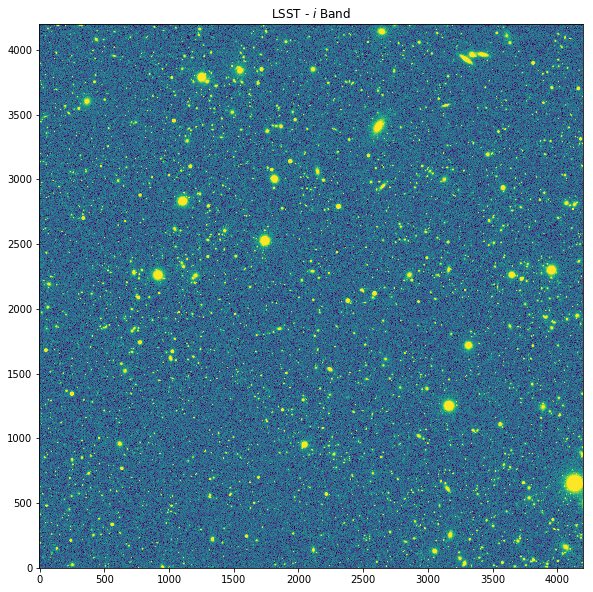

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
lsst_iband_img = random_lsst_exp.image.array
print(f"Plotting img from tract {random_coaddId['tract']} and patch {random_coaddId['patch']}")
ax.set_title(r'LSST - $i$ Band')
ax.imshow(lsst_iband_img, norm=asinh_norm(lsst_iband_img, a=0.1), origin='lower', cmap='viridis')